In [37]:
import pandas as pd

from ast import literal_eval
from rdkit.Chem import Draw, Mol, MolFromSmiles, PandasTools, rdmolops
from rdkit.Chem.Draw import MolsToGridImage

from ipywidgets import interact, widgets
from rdkit.Chem.Draw.MolDrawing import DrawingOptions
DrawingOptions.includeAtommNumbers = False

def hsvToRgb(h, s, v):
    h /= 60.0
    c = v * s
    x = c * (1 - abs(h % 2 - 1))
    if 0 <= h < 1:
        r, g, b = (c, x, 0)
    elif 1 <= h < 2:
        r, g, b = (x, c, 0)
    elif 2 <= h < 3:
        r, g, b = (0, c, x)
    elif 3 <= h < 4:
        r, g, b = (0, x, c)
    elif 4 <= h < 5:
        r, g, b = (x, 0, c)
    else:
        r, g, b = (c, 0, x)
    m = v - c
    return (max(0,r+m), max(0,g+m), max(0,b+m))

### Visualize predictions for individual molecules

In [47]:
mol = MolFromSmiles('CCN1CCN(CC2=CC=C(NC3=NC=C(F)C(=N3)C3=CC(F)=C4N=C(C)N(C(C)C)C4=C3)N=C2)CC1')
mol.Compute2DCoords()
results = pd.read_csv('output/M7/abemaciclib/results.csv')

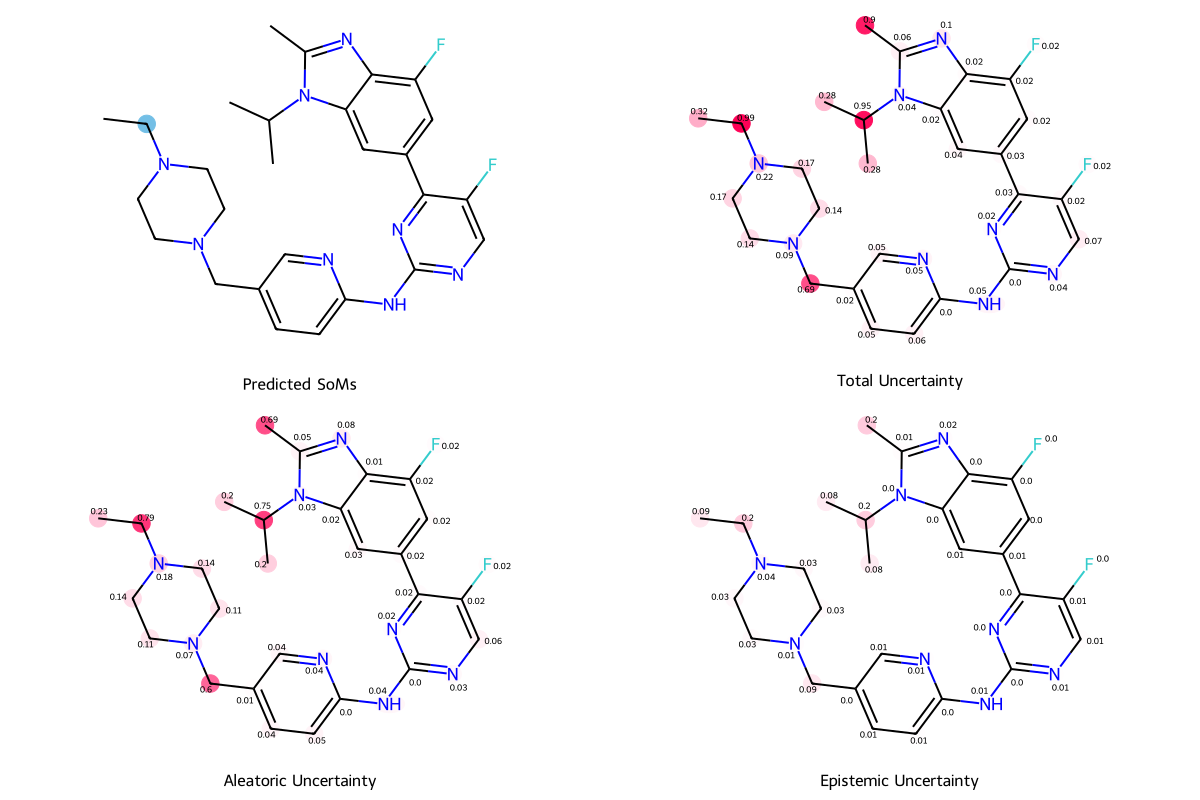

In [49]:
pred_soms = [i for i, x in enumerate(results.y_pred) if x]

highlights_u_ale = {}
mol_u_ale = mol.__copy__()
for atom in mol_u_ale.GetAtoms():
    label = results.u_ale[atom.GetIdx()]
    atom.SetProp('atomNote', str(round(label,2)))
    highlights_u_ale[atom.GetIdx()] = hsvToRgb(500, label, 1.0)

highlights_u_epi = {}
mol_u_epi = mol.__copy__()
for atom in mol_u_epi.GetAtoms():
    label = results.u_epi[atom.GetIdx()]
    atom.SetProp('atomNote', str(round(label,2)))
    highlights_u_epi[atom.GetIdx()] = hsvToRgb(500, label, 1.0)

highlights_u_tot = {}
mol_u_tot = mol.__copy__()
for atom in mol_u_tot.GetAtoms():
    label = results.u_tot[atom.GetIdx()]
    atom.SetProp('atomNote', str(round(label,2)))
    highlights_u_tot[atom.GetIdx()] = hsvToRgb(500, label, 1.0)

drawing = MolsToGridImage(
    [mol, mol_u_tot, mol_u_ale, mol_u_epi], 
    molsPerRow=2, 
    highlightAtomLists=[pred_soms, highlights_u_tot, highlights_u_ale, highlights_u_epi], 
    highlightBondLists=[{}, {}, {}, {}],
    highlightAtomColors=[{i: hsvToRgb(200, 0.5, 0.9) for i in pred_soms}, highlights_u_tot, highlights_u_ale, highlights_u_epi, ],
    subImgSize=(600, 400), 
    legends=['Predicted SoMs', 'Total Uncertainty', 'Aleatoric Uncertainty', 'Epistemic Uncertainty']
)
opt = Draw.DrawingOptions()
opt.fontFile = "BuiltinRobotoRegular"
display(drawing)

Abemaciclib mainly undergoes hepatic metabolism mediated by CYP3A4. The major metabolite formed is N-desethylabemaciclib (correctly predicted by the example version of AweSOM), while other metabolites hydroxyabemaciclib, hydroxy-N-desethylabemaciclib, and an oxidative metabolite are also formed. (source: drugbank)

### Visualize predictions for toy test set

In [20]:
# Import example data
data = PandasTools.LoadSDF('data/test/raw/data.sdf', removeHs=False)
data['ID'] = data['ID'].astype(int)
data['soms'] = data['soms'].map(literal_eval)

# Import example results
results = pd.read_csv('output/M7/test/results.csv')

# Merge data and results
results = results.rename(columns={"mol_id": "ID"})
results_grouped = results.groupby('ID').agg({
    'y_true': lambda x: list(x),
    'y_prob': lambda x: list(x),
    'y_pred': lambda x: list(x),
    'ranking': lambda x: list(x),
    'u_ale': lambda x: list(x),
    'u_epi': lambda x: list(x),
    'u_tot': lambda x: list(x),   
}).reset_index()
results_merged = pd.merge(results_grouped, data, on=['ID'], how='left')

In [34]:
@interact(i=widgets.IntSlider(min=0, max=len(results_merged)-1, step=1))
def f(i):

    row = results_merged.iloc[i]

    mol = Mol(row.ROMol)
    mol.Compute2DCoords()
    rdmolops.RemoveStereochemistry(mol)
    for atom in mol.GetAtoms():
        atom.SetAtomMapNum(0)
    
    mol_predictions = mol.__copy__()

    true_soms = row.soms
    pred_soms = [i for i, x in enumerate(row.y_pred) if x]

    highlights_u_ale = {}
    mol_u_ale = mol.__copy__()
    for atom in mol_u_ale.GetAtoms():
        label = row.u_ale[atom.GetIdx()]
        atom.SetProp('atomNote', str(round(label,2)))
        highlights_u_ale[atom.GetIdx()] = hsvToRgb(500, label, 1.0)

    highlights_u_epi = {}
    mol_u_epi = mol.__copy__()
    for atom in mol_u_epi.GetAtoms():
        label = row.u_epi[atom.GetIdx()]
        atom.SetProp('atomNote', str(round(label,2)))
        highlights_u_epi[atom.GetIdx()] = hsvToRgb(500, label, 1.0)

    highlights_u_tot = {}
    mol_u_tot = mol.__copy__()
    for atom in mol_u_tot.GetAtoms():
        label = row.u_tot[atom.GetIdx()]
        atom.SetProp('atomNote', str(round(label,2)))
        highlights_u_tot[atom.GetIdx()] = hsvToRgb(500, label, 1.0)

    drawing = MolsToGridImage(
        [mol, mol_predictions, mol_u_ale, mol_u_epi, mol_u_tot], 
        molsPerRow=2, 
        highlightAtomLists=[true_soms, pred_soms, highlights_u_ale, highlights_u_epi, highlights_u_tot], 
        highlightBondLists=[{}, {}, {}, {}, {}],
        highlightAtomColors=[{i: hsvToRgb(100, 0.5, 0.9) for i in true_soms}, {i: hsvToRgb(200, 0.5, 0.9) for i in pred_soms}, highlights_u_ale, highlights_u_epi, highlights_u_tot],
        subImgSize=(600, 400), 
        legends=['Experimentally confirmed SoMs', 'Predicted SoMs', 'Aleatoric Uncertainty', 'Epistemic Uncertainty', 'Total Uncertainty']
    )
    opt = Draw.DrawingOptions()
    opt.fontFile = "BuiltinRobotoRegular"
    display(drawing)

interactive(children=(IntSlider(value=0, description='i', max=131), Output()), _dom_classes=('widget-interact'…